In [1]:
%env CUDA_VISIBLE_DEVICES=7
%env OMP_NUM_THREADS=16

env: CUDA_VISIBLE_DEVICES=7
env: OMP_NUM_THREADS=16


In [2]:
import torch
torch.set_grad_enabled(False)

In [3]:
# MODEL = "meta-llama/Llama-2-7b-hf"
MODEL = "meta-llama/Meta-Llama-3.1-8B"
BASE_PPL = 5.606886386871338

In [4]:
from transformers import AutoModelForCausalLM

MODEL_PATH = 'meta-llama/Meta-Llama-3.1-8B'
MODEL_SEQLEN = 8192

model_pt = AutoModelForCausalLM.from_pretrained(
    MODEL_PATH,
    trust_remote_code=True, torch_dtype="auto", device_map='cpu',
)

def get_module_by_path(model, path):
    if path == '':
        return model
    splitted = path.split('.', 1)
    if len(splitted) == 1:
        splitted.append('')
    next_name, suffix = splitted

    try:
        next_module = model[int(next_name)]
    except:
        next_module = getattr(model, next_name)

    return get_module_by_path(next_module, suffix)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [5]:
from eval import *

testloader = get_loaders(
    'wikitext2',
    seed=0,
    model_path=MODEL_PATH,
    seqlen=MODEL_SEQLEN,
    eval_mode=True,
    use_fast_tokenizer=False,
    trust_remote_code=False,
)

def eval_ppl(
    model,
    model_path=MODEL_PATH,
    model_seqlen=MODEL_SEQLEN,
    device = 'cuda:0',
    # ppl_datasets = ('wikitext2',),
    trust_remote_code=False,
    offload_activations=False,
):
    output = {}
    
    ppl = perplexity_eval(
        model,
        testloader,
        dataset_name='wikitext2',
        model_seqlen=model_seqlen,
        device=device,
        offload_activations=offload_activations,
    )
    output['wikitext2'] = ppl
    # make sure that the cache is released
    torch.cuda.empty_cache()
    
    return output

Token indices sequence length is longer than the specified maximum sequence length for this model (289077 > 131072). Running this sequence through the model will result in indexing errors


In [6]:
import torch
import bitsandbytes as bnb

@torch.no_grad()
def _quantize_dequantize_bnb_8(weight):
    out_features, in_features = weight.shape
    w = bnb.nn.Linear8bitLt(
        in_features,
        out_features,
        bias=False,
        has_fp16_weights=False,
        threshold=6.0,  # Default from the LLM.int8() paper
    )
    w.weight = bnb.nn.Int8Params(
        weight, requires_grad=False, has_fp16_weights=False
    ).to(weight.dtype)
    w.cuda()

    # hacky dequantization
    output = w(torch.eye(in_features).half().cuda()).T.contiguous()

    assert output.shape == weight.shape, (output.shape, weight.shape)

    return output


@torch.no_grad()
def quantize_dequantize_bnb_8(weight):
    # chunked processing for large in_features
    
    BLOCK_SIZE = 8192
    
    out_features, in_features = weight.shape
    
    output = []
    for begin in range(0, in_features, BLOCK_SIZE):
        end = min(begin + BLOCK_SIZE, in_features)

        chunk = weight[:, begin:end]
        
        output.append(
            _quantize_dequantize_bnb_8(chunk)
        )

    return torch.cat(output, dim=1)


@torch.no_grad()
def _quantize_dequantize_bnb_4(weight):
    out_features, in_features = weight.shape
    w = bnb.nn.LinearNF4(
        in_features,
        out_features,
        bias=False,
    )
    w.weight = bnb.nn.Params4bit(
        weight, requires_grad=False, quant_type="nf4", blocksize=64,
    ).to(weight.dtype)
    w.cuda()
    
    output = w(torch.eye(in_features).half().cuda()).T.contiguous()

    assert output.shape == weight.shape, (output.shape, weight.shape)

    return output


@torch.no_grad()
def quantize_dequantize_bnb_4(weight):
    # chunked processing for large in_features
    
    BLOCK_SIZE = 8192
    
    out_features, in_features = weight.shape
    
    output = []
    for begin in range(0, in_features, BLOCK_SIZE):
        end = min(begin + BLOCK_SIZE, in_features)

        chunk = weight[:, begin:end]
        
        output.append(
            _quantize_dequantize_bnb_4(chunk)
        )

    return torch.cat(output, dim=1)

In [7]:
import functools


@functools.cache
def get_numel(path):
    return get_module_by_path(model_pt, path).weight.numel()

total_params = sum(p.numel() for p in model_pt.model.layers.parameters())

In [8]:
import tqdm
import pandas as pd 
import wandb
import functools


@functools.cache
def get_df_from_wandb(path):
    api = wandb.Api()

    # Project is specified by <entity/project-name>
    runs = api.runs(path)
    
    data_df_lines = []
    for run in tqdm.tqdm(runs): 
        data_df_lines.append({
            'Name': run.name,
            'Commit': run.commit,
            **run.summary._json_dict,
            **{k: v for k,v in run.config.items() if not k.startswith('_')},
        })
    data_df = pd.DataFrame(data_df_lines)
    return data_df

In [9]:
# data_df = get_df_from_wandb('rock-and-roll/NOISY_MSE_ONE_LAYER_GALQIWI_PPL')
# data_df.to_csv('blockwise_slopes.csv')
data_df = pd.read_csv('blockwise_slopes.csv')

data_df['mse'] = data_df['relative_mse']

data_df = data_df[data_df['base_model'] == MODEL]

data_df = data_df[['layer_idx', 'mse', 'wikitext2']]
data_df = data_df.dropna().copy()

from sklearn.linear_model import LinearRegression


slopes = []
intercepts = []

for layer_idx in range(32):
    to_fit = data_df[data_df['layer_idx'] == layer_idx]
    to_fit = to_fit[to_fit['mse'] < 4 ** -1.7]
    # to_fit = to_fit[to_fit['wikitext2'] < 5.640]

    slope = LinearRegression(fit_intercept=False).fit(to_fit['mse'].values.reshape(-1, 1), to_fit['wikitext2'] - BASE_PPL).coef_
    
    slopes.append(slope.item())
    intercepts.append(BASE_PPL)

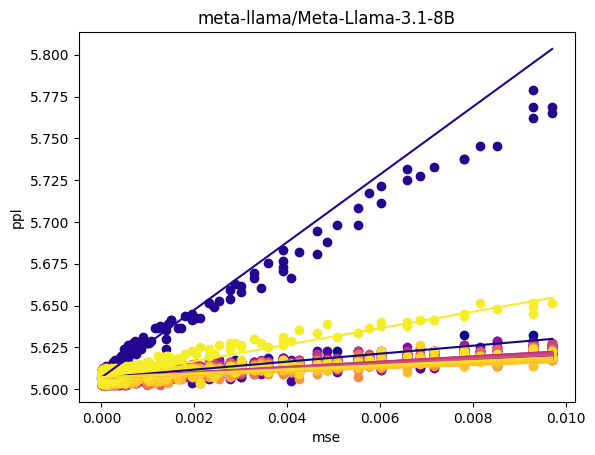

In [10]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


cmap = matplotlib.colormaps["plasma"]

plt.scatter([0.0], [BASE_PPL])

for layer_idx in range(32):
# for layer_idx, layer in enumerate(layers):
    to_plot = data_df[data_df['layer_idx'] == layer_idx]
    to_plot = to_plot[to_plot['mse'] < 0.01]
    # to_plot = to_plot[to_plot['wikitext2'] < 5.640]
    
    plt.scatter(to_plot['mse'], to_plot['wikitext2'], color=cmap(layer_idx / 32))

    grid = np.linspace(0, to_plot['mse'].max(), 10)
    
    plt.plot(grid, intercepts[layer_idx] + grid * slopes[layer_idx], color=cmap(layer_idx / 32))


plt.title(f'{MODEL}')
plt.xlabel('mse')
plt.ylabel('ppl')
plt.savefig(f'ppl_mse.png')

In [11]:
from ortools.linear_solver import pywraplp

def find_grids_with_budget(
    slopes,    # linear coefficients for [layerwise mse -> metric]
    weights,   # linear coefficients for [layer bitwidth -> total bitwidth] (1 / num_blocks for blockwise)
    budget,    # upper bound on total bitwidth
    grid_bits, # available grid bitwidths
    grid_mses  # available grid mses
) -> tuple[float, list]:
    num_layers = len(slopes)
    num_grids = len(grid_bits)
    assert len(grid_mses) == num_grids
    
    solver = pywraplp.Solver.CreateSolver("CP-SAT")

    x = {(j, i) : solver.BoolVar("name") for i in range(num_grids) for j in range(num_layers)}
    
    for j in range(num_layers) : solver.Add(sum(x[(j, i)] for i in range(num_grids)) == 1)
    solver.Add(sum(x[(j, i)] * weights[j] * grid_bits[i] for j in range(num_layers) for i in range(num_grids)) <= budget)
    solver.Minimize(sum(x[(j, i)] * slopes[j] * grid_mses[i] for j in range(num_layers) for i in range(num_grids)))

    status = solver.Solve()
    if status == pywraplp.Solver.OPTIMAL:
        avg_bits = sum(x[(j, i)].solution_value() * weights[j] * grid_bits[i] for j in range(num_layers) for i in range(num_grids))
        solution = np.asarray([[x[(j, i)].solution_value() for i in range(num_grids)] for j in range(num_layers)])
        indices = np.argwhere(solution == 1.0)
        assert len(indices) == num_layers
        return avg_bits, indices[:,1]
    else:
        raise Exception("Didn't solve")

In [12]:
test_input = torch.randn((1024, 1024), device='cuda')

ok_grids = pd.DataFrame([{
    'name': 'fp16',
    'bits': 16,
    'mse': 0.0, # should be zero, but it breaks solver
}, {
    'name': 'bnb-8',
    'bits': 8 + 16 / 1026,
    'mse': 0.00017070770263671875,
}, {
    'name': 'bnb-4',
    'bits': 4 + 16 / 64,
    'mse': 0.0084228515625,
}])

ok_grids

,name,bits,mse
0,fp16,16.000000,0.000000
1,bnb-8,8.015595,0.000171
2,bnb-4,4.250000,0.008423


In [13]:
grid_names=ok_grids['name'].values
grid_bits=ok_grids['bits'].values
grid_mses=ok_grids['mse'].values

solution_size, solution_idxs = find_grids_with_budget(
    slopes,
    np.ones((32,)) / 32,
    budget=8,
    grid_bits=ok_grids['bits'].values,
    grid_mses=ok_grids['mse'].values,
)

print(f'{solution_size} bits')

7.897919712475634 bits


In [14]:
def get_solution(n_bits = 8):
    solution_size, solution_idxs = find_grids_with_budget(
        slopes,
        np.ones((32,)) / 32,
        budget=n_bits,
        grid_bits=ok_grids['bits'].values,
        grid_mses=ok_grids['mse'].values,
    )

    solution_pred_err = sum([scale * ok_grids['mse'].values[solution_idx] for solution_idx, scale in zip(solution_idxs, slopes)])

    return solution_size, solution_pred_err, solution_idxs

In [15]:
grid = np.linspace(4.25, 12, 40)

bnb_pred_lines = []

for n_bits in tqdm.tqdm(grid):
    solution_size, solution_pred_err, solution_idxs = get_solution(n_bits)
    bnb_pred_lines.append({
        'solution_size': solution_size,
        'solution_pred_err': solution_pred_err,
    })

bnb_pred_df = pd.DataFrame(bnb_pred_lines)

100%|██████████| 40/40 [00:02<00:00, 15.20it/s]


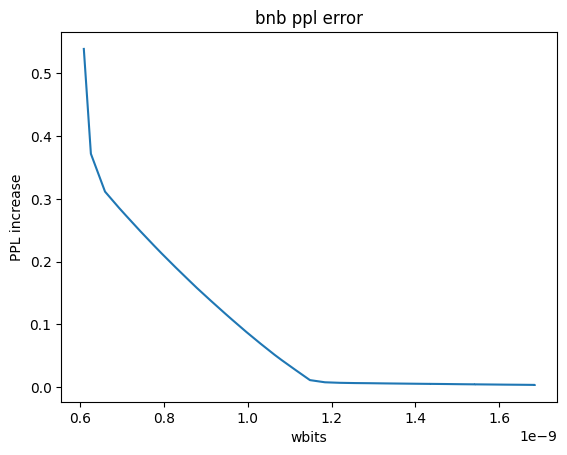

In [16]:
plt.title('bnb ppl error')
plt.ylabel('PPL increase')
plt.xlabel('wbits')
plt.plot(bnb_pred_df['solution_size'] / total_params, bnb_pred_df['solution_pred_err'])

plt.show()

In [17]:
def get_module_by_path(model, path):
    if path == '':
        return model
    splitted = path.split('.', 1)
    if len(splitted) == 1:
        splitted.append('')
    next_name, suffix = splitted

    try:
        next_module = model[int(next_name)]
    except:
        next_module = getattr(model, next_name)

    return get_module_by_path(next_module, suffix)

In [18]:
model_pt = model_pt.cuda()

In [19]:
BASELINE_PPL = eval_ppl(model_pt)['wikitext2']
BASELINE_PPL

The attention layers in this model are transitioning from computing the RoPE embeddings internally through `position_ids` (2D tensor with the indexes of the tokens), to using externally computed `position_embeddings` (Tuple of tensors, containing cos and sin). In v4.45 `position_ids` will be removed and `position_embeddings` will be mandatory.


5.606260776519775

In [20]:
model_state_dict = model_pt.state_dict()

In [21]:
layer_names = [f"model.layers.{i}.self_attn.{name}_proj" for i in range(32) for name in ("q","k","v","o")] + \
    [f"model.layers.{i}.mlp.{name}_proj" for i in range(32) for name in ("gate","up","down")]

In [22]:
model_state_dict_4bit = {
    layer: quantize_dequantize_bnb_4(model_state_dict[f'{layer}.weight']).cpu()
    for layer in tqdm.tqdm(layer_names)
}

100%|██████████| 224/224 [00:42<00:00,  5.27it/s]


In [23]:
model_state_dict_8bit = {
    layer: quantize_dequantize_bnb_8(model_state_dict[f'{layer}.weight']).cpu()
    for layer in tqdm.tqdm(layer_names)
}

100%|██████████| 224/224 [00:43<00:00,  5.20it/s]


In [24]:
import tqdm
import copy

def eval_quantized_model(solution_idxs):
    quantized_model = copy.deepcopy(model_pt)
    
    for i, quant_idx in enumerate(solution_idxs):
        for layer_name in [f"model.layers.{i}.self_attn.{name}_proj" for name in ("q","k","v","o")] + \
            [f"model.layers.{i}.mlp.{name}_proj" for name in ("gate","up","down")]:
            layer = get_module_by_path(quantized_model, layer_name)
            weight = layer.weight
            if quant_idx == 1:
                weight = model_state_dict_8bit[layer_name]
            if quant_idx == 2:
                weight = model_state_dict_4bit[layer_name]
            layer.weight.data = weight.to(torch.bfloat16)

    return eval_ppl(quantized_model)['wikitext2'] - BASELINE_PPL

In [25]:
grid = np.linspace(4.25, 8.1, 10)

bnb_real_lines = []

for n_bits in tqdm.tqdm(grid):
    solution_size, solution_pred_err, solution_idxs = get_solution(n_bits)
    real_err = eval_quantized_model(solution_idxs)
    bnb_real_lines.append({
        'solution_size': solution_size,
        'solution_pred_err': solution_pred_err,
        'solution_real_err': real_err,
    })

100%|██████████| 10/10 [14:10<00:00, 85.06s/it]


In [26]:
bnb_real_df = pd.DataFrame(bnb_real_lines)

In [27]:
bnb_real_df['solution_pred_err'] / bnb_real_df['solution_real_err']

0    1.496355
1    1.180850
2    1.179970
3    1.201391
4    1.210817
5    1.233935
6    1.231158
7    1.144682
8    1.108080
9    1.246201
dtype: float64

Text(0, 0.5, 'real ppl err')

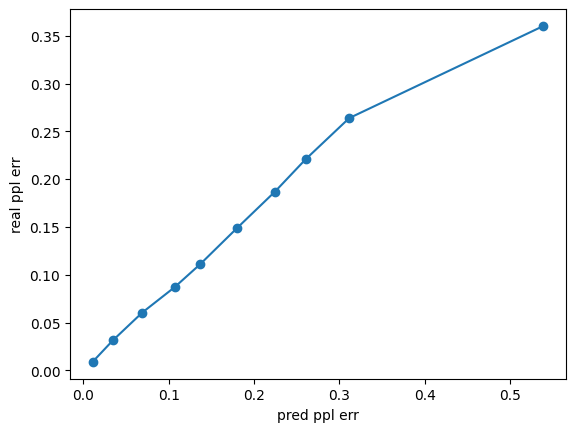

In [28]:
plt.scatter(bnb_real_df['solution_pred_err'], bnb_real_df['solution_real_err'])
plt.plot(bnb_real_df['solution_pred_err'], bnb_real_df['solution_real_err'])
plt.xlabel('pred ppl err')
plt.ylabel('real ppl err')

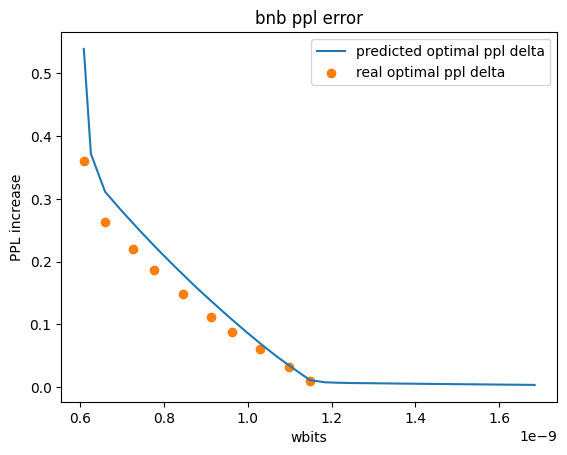

In [29]:
import matplotlib as mpl

plt.title('bnb ppl error')
plt.ylabel('PPL increase')
plt.xlabel('wbits')
plt.plot(bnb_pred_df['solution_size'] / total_params, bnb_pred_df['solution_pred_err'], label='predicted optimal ppl delta')
plt.scatter(bnb_real_df['solution_size'] / total_params, bnb_real_df['solution_real_err'], color=mpl.colormaps['tab10'](1), label='real optimal ppl delta')

plt.legend()

plt.show()

In [30]:
bnb_pred_df.to_csv('blockwise_bnb_pred_df.csv')
bnb_real_df.to_csv('blockwise_bnb_real_df.csv')